In [6]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [7]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [8]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [9]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [10]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

In [11]:
# get to know about which crime category

crime_count = crimeDF.groupBy('Category')\
           .agg({'IncidntNum' : 'count'})\
           .select(col('count(IncidntNum)').alias('catCount'),col('Category'))\
           .orderBy('catCount')
crime_count.show(40,False)

+--------+---------------------------+
|catCount|Category                   |
+--------+---------------------------+
|14      |TREA                       |
|59      |PORNOGRAPHY/OBSCENE MAT    |
|348     |GAMBLING                   |
|431     |SEX OFFENSES, NON FORCIBLE |
|741     |EXTORTION                  |
|813     |BRIBERY                    |
|925     |BAD CHECKS                 |
|1183    |FAMILY OFFENSES            |
|1292    |SUICIDE                    |
|2430    |LOITERING                  |
|2988    |EMBEZZLEMENT               |
|3931    |ARSON                      |
|4083    |LIQUOR LAWS                |
|4440    |RUNAWAY                    |
|5346    |KIDNAPPING                 |
|5672    |DRIVING UNDER THE INFLUENCE|
|8716    |RECOVERED VEHICLE          |
|9826    |DRUNKENNESS                |
|10040   |DISORDERLY CONDUCT         |
|11742   |SEX OFFENSES, FORCIBLE     |
|11891   |STOLEN PROPERTY            |
|16701   |PROSTITUTION               |
|19449   |TRESPASS       

In [5]:
crime_count.where((col('catCount')>100000)&(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES'])))\
.select('Category').collect()

NameError: name 'crime_count' is not defined

In [8]:
_df = crime_count.orderBy('catCount').toPandas()
categories = _df.Category
n_categories = range(len(categories))
ind = np.arange(len(categories))

<BarContainer object of 39 artists>

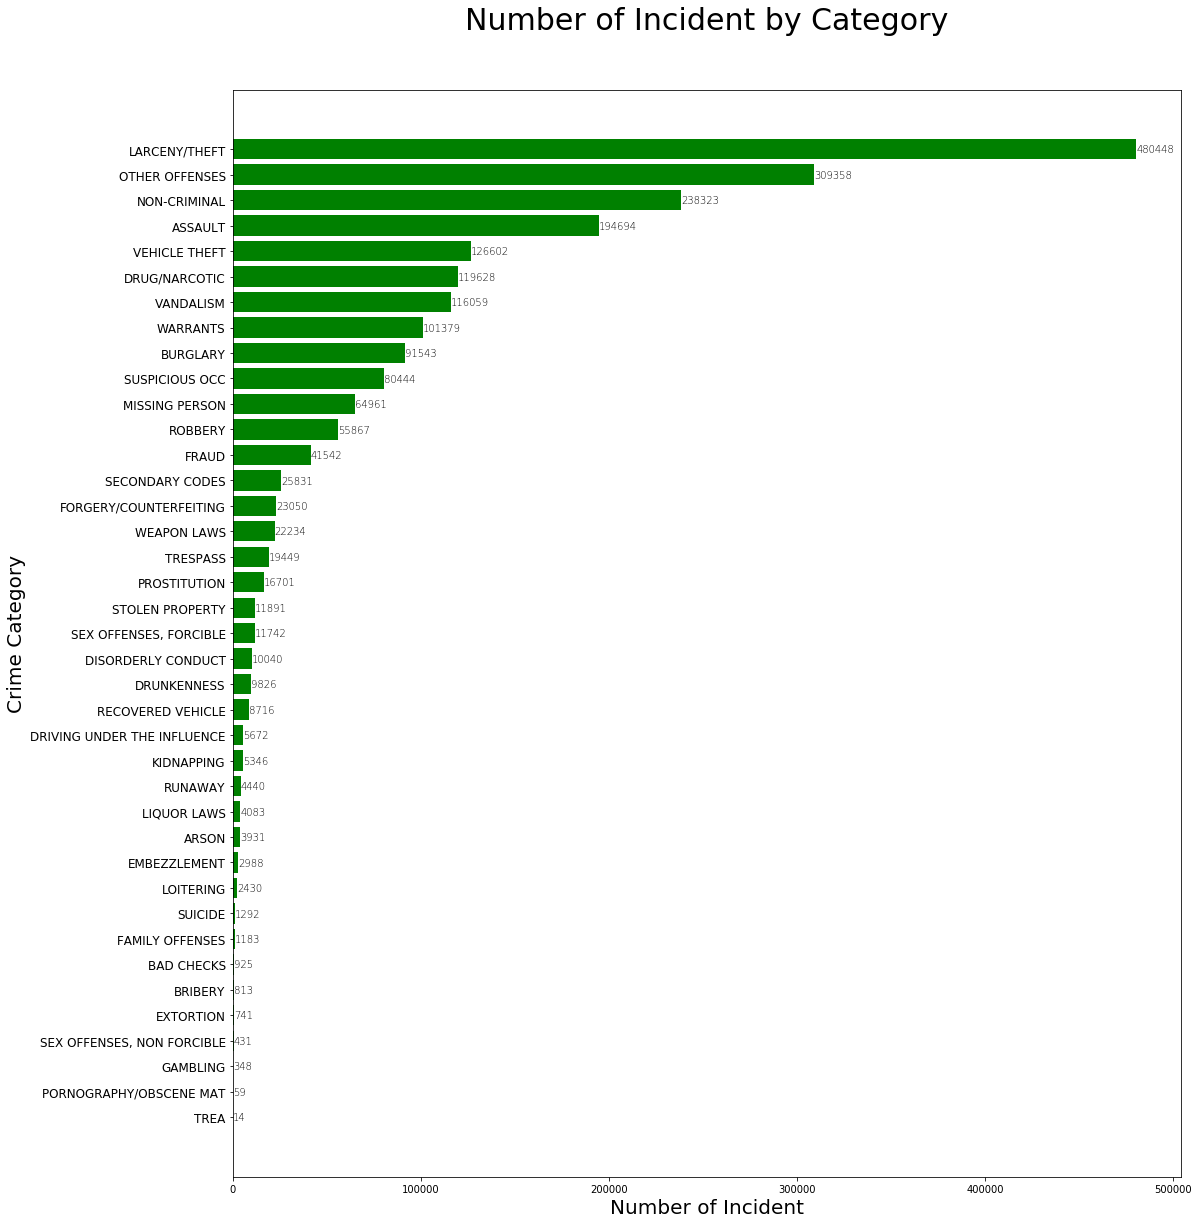

In [16]:
fig = plt.figure(figsize=(17,20))

ax = fig.add_subplot(111)
ax.set_yticklabels(categories, size="12")
ax.set_yticks(ind)
ax.set_ylabel("Crime Category",size="20")
ax.set_xlabel('Number of Incident',size="20")
ax.set_title('Number of Incident by Category', size=30, y=1.05)
for i, v in enumerate(_df.catCount):
    ax.text(v + 3, i - .125, str(v), fontweight='light')

ax.barh(n_categories,_df.catCount, color = 'green')

In [208]:
categories = [u'ARSON', u'ASSAULT', u'BAD CHECKS', u'BRIBERY', u'BURGLARY', u'DISORDERLY CONDUCT',\
              u'DRIVING UNDER THE INFLUENCE', u'DRUG/NARCOTIC', u'DRUNKENNESS', u'EMBEZZLEMENT', \
              u'EXTORTION', u'FAMILY OFFENSES', u'FORGERY/COUNTERFEITING', u'FRAUD', u'GAMBLING', \
              u'KIDNAPPING', u'LARCENY/THEFT', u'LIQUOR LAWS', u'LOITERING', u'MISSING PERSON', \
              u'NON-CRIMINAL', u'OTHER OFFENSES', u'PORNOGRAPHY/OBSCENE MAT', u'PROSTITUTION', \
              u'RECOVERED VEHICLE', u'ROBBERY', u'RUNAWAY', u'SECONDARY CODES', \
              u'SEX OFFENSES, FORCIBLE', u'SEX OFFENSES, NON FORCIBLE', u'STOLEN PROPERTY', \
              u'SUICIDE', u'SUSPICIOUS OCC', u'TREA', u'TRESPASS', u'VANDALISM', u'VEHICLE THEFT',\
              u'WARRANTS', u'WEAPON LAWS']

In [6]:
def preparePlot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                gridWidth=1.0):
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

In [206]:
# Know about the crime Category in each Hour

hr_cat = crimeDF.select('Hour','Category').orderBy('Category','Hour').groupBy('Hour','Category')
hr_cat_list = hr_cat.agg({"*": "count"}).collect()
# categories = crime_count.select('Category').rdd.map(lambda x: x[0]).collect()
n_categories = len(categories)
# matrix where the x-axis is the hour, and y-axis is the category
img_hr_cat = np.zeros((n_categories, 24))

In [115]:
hr_cat_list

[Row(Hour=0, Category=u'ARSON', count(1)=257),
 Row(Hour=1, Category=u'ARSON', count(1)=244),
 Row(Hour=2, Category=u'ARSON', count(1)=264),
 Row(Hour=3, Category=u'ARSON', count(1)=262),
 Row(Hour=4, Category=u'ARSON', count(1)=219),
 Row(Hour=5, Category=u'ARSON', count(1)=170),
 Row(Hour=6, Category=u'ARSON', count(1)=117),
 Row(Hour=7, Category=u'ARSON', count(1)=89),
 Row(Hour=8, Category=u'ARSON', count(1)=93),
 Row(Hour=9, Category=u'ARSON', count(1)=82),
 Row(Hour=10, Category=u'ARSON', count(1)=86),
 Row(Hour=11, Category=u'ARSON', count(1)=83),
 Row(Hour=12, Category=u'ARSON', count(1)=112),
 Row(Hour=13, Category=u'ARSON', count(1)=120),
 Row(Hour=14, Category=u'ARSON', count(1)=117),
 Row(Hour=15, Category=u'ARSON', count(1)=140),
 Row(Hour=16, Category=u'ARSON', count(1)=120),
 Row(Hour=17, Category=u'ARSON', count(1)=157),
 Row(Hour=18, Category=u'ARSON', count(1)=153),
 Row(Hour=19, Category=u'ARSON', count(1)=165),
 Row(Hour=20, Category=u'ARSON', count(1)=196),
 Row(Ho

In [209]:
# add the frequencies of crime per hour in the matrix
for row in hr_cat_list:
    hour = row[0]
    category = row[1]
    value = row[2]
    img_hr_cat[categories.index(category)][hour] = value
    
# change grey scale of each box
for row in img_hr_cat:
    m = max(row)
    for idx in range(len(row)):
        row[idx] = row[idx] / m

In [210]:
print(img_hr_cat)

[[9.73484848e-01 9.24242424e-01 1.00000000e+00 9.92424242e-01
  8.29545455e-01 6.43939394e-01 4.43181818e-01 3.37121212e-01
  3.52272727e-01 3.10606061e-01 3.25757576e-01 3.14393939e-01
  4.24242424e-01 4.54545455e-01 4.43181818e-01 5.30303030e-01
  4.54545455e-01 5.94696970e-01 5.79545455e-01 6.25000000e-01
  7.42424242e-01 7.34848485e-01 8.93939394e-01 9.65909091e-01]
 [1.00000000e+00 8.52694611e-01 7.72823584e-01 3.94564717e-01
  2.50760018e-01 2.01566099e-01 2.66328881e-01 3.95117457e-01
  6.01289728e-01 6.64210041e-01 7.34315983e-01 7.81391064e-01
  9.68770152e-01 8.40165822e-01 8.54813450e-01 9.57991709e-01
  9.43251958e-01 9.62874251e-01 9.45739291e-01 9.24827269e-01
  9.12298480e-01 9.46384155e-01 9.05389222e-01 8.58314141e-01]
 [8.70967742e-01 1.61290323e-02 1.07526882e-02 1.61290323e-02
  1.61290323e-02 1.07526882e-02 1.61290323e-02 6.45161290e-02
  2.63440860e-01 3.49462366e-01 3.17204301e-01 2.47311828e-01
  1.00000000e+00 2.47311828e-01 2.79569892e-01 3.38709677e-01
  2.74

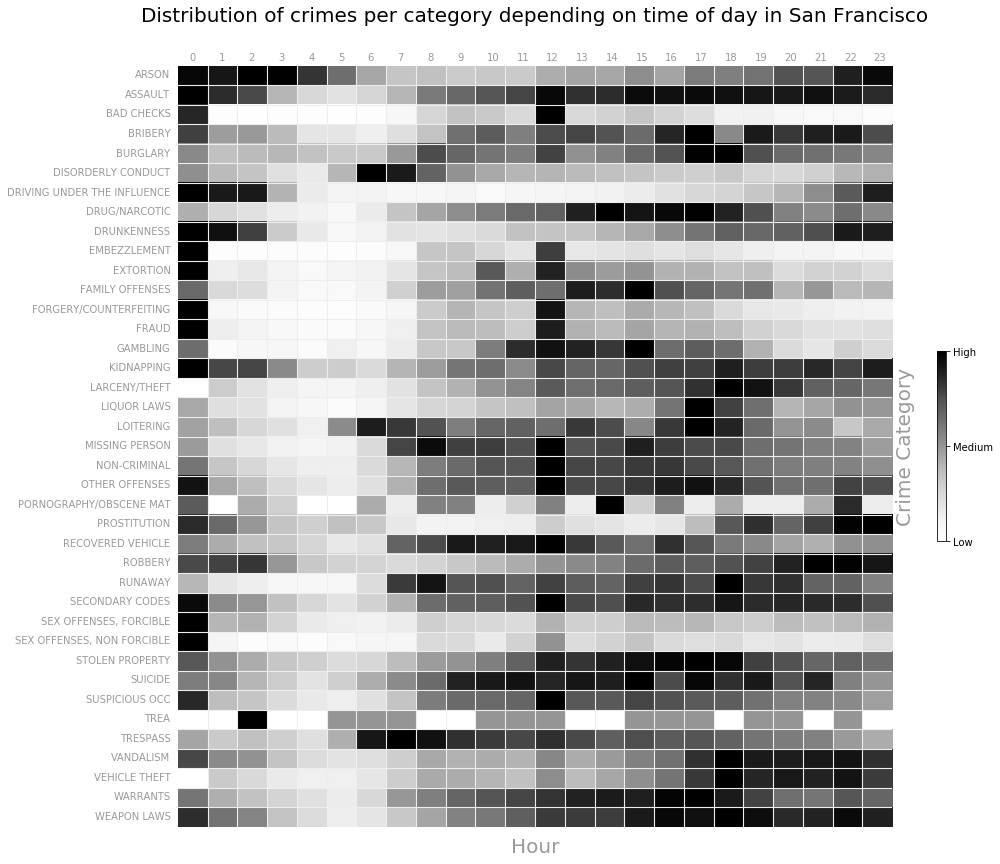

In [211]:
# draw grid on axes
fig, ax = preparePlot(np.arange(.5, 23, 1), np.arange(.5, n_categories-1, 1), figsize=(16,14), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_hr_cat, interpolation='nearest', aspect='auto', cmap=cm.Greys)

# x-axis labels
for x, y, s in zip(np.arange(-.125, 24, 1), np.repeat(-.75, 24), [str(x) for x in range(24)]):
    plt.text(x, y, s, color='#999999', size='10')
# y-axis labels
for x, y, s in zip(np.repeat(-.75, n_categories), np.arange(.125, n_categories, 1), categories):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="right")
# title, xlabel, ylabel
plt.title("Distribution of crimes per category depending on time of day in San Francisco", size=20, y=1.05)
plt.xlabel("Hour", color='#999999', size="20")
plt.ylabel("Crime Category", color='#999999', size="20")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()

In [121]:
# Know about the crime month in each Hour

hr_month = crimeDF.select('Hour','Month').where((col('Hour').isNotNull())|col('Month').isNotNull())\
            .orderBy('Month','Hour').groupBy('Hour','Month')
hr_month_list = hr_month.agg({"*": "count"}).collect()
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
          'August', 'September', 'October', 'November', 'December']
n_months = 12
# matrix where the x-axis is the hour, and y-axis is the category
img_hr_month = np.zeros((12, 24))

In [122]:
hr_month_list

[Row(Hour=0, Month=1, count(1)=10876),
 Row(Hour=1, Month=1, count(1)=5972),
 Row(Hour=2, Month=1, count(1)=5053),
 Row(Hour=3, Month=1, count(1)=3164),
 Row(Hour=4, Month=1, count(1)=2382),
 Row(Hour=5, Month=1, count(1)=2111),
 Row(Hour=6, Month=1, count(1)=2919),
 Row(Hour=7, Month=1, count(1)=4791),
 Row(Hour=8, Month=1, count(1)=7413),
 Row(Hour=9, Month=1, count(1)=8088),
 Row(Hour=10, Month=1, count(1)=8481),
 Row(Hour=11, Month=1, count(1)=8566),
 Row(Hour=12, Month=1, count(1)=11792),
 Row(Hour=13, Month=1, count(1)=9690),
 Row(Hour=14, Month=1, count(1)=10027),
 Row(Hour=15, Month=1, count(1)=10481),
 Row(Hour=16, Month=1, count(1)=11352),
 Row(Hour=17, Month=1, count(1)=11679),
 Row(Hour=18, Month=1, count(1)=12838),
 Row(Hour=19, Month=1, count(1)=11300),
 Row(Hour=20, Month=1, count(1)=10326),
 Row(Hour=21, Month=1, count(1)=9550),
 Row(Hour=22, Month=1, count(1)=9882),
 Row(Hour=23, Month=1, count(1)=8851),
 Row(Hour=0, Month=2, count(1)=8824),
 Row(Hour=1, Month=2, count

In [123]:
# add the frequencies of crime per hour in the matrix
for row in hr_month_list:
    hour = row[0]
    month = row[1]
    value = row[2]
    img_hr_month[month-1][hour] = value
    
# change grey scale of each box
for row in img_hr_month:
    m = max(row)
    for idx in range(len(row)):
        row[idx] = row[idx] / m

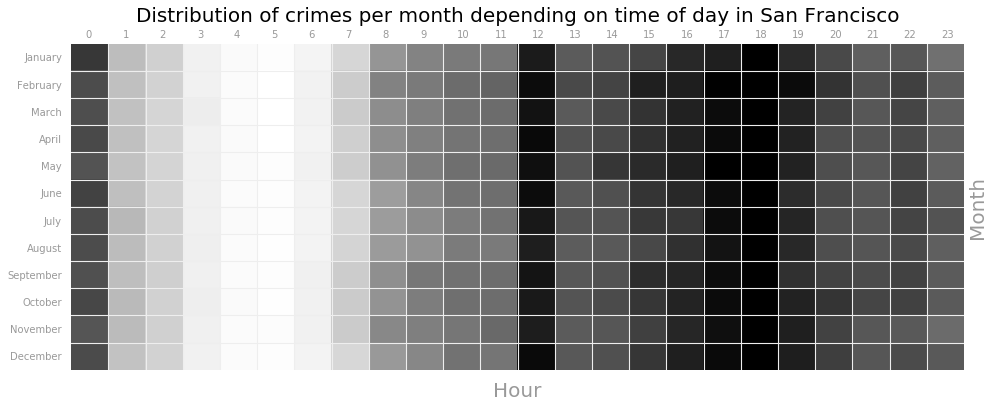

In [124]:
# draw grid on axes
fig, ax = preparePlot(np.arange(.5, 23, 1), np.arange(.5, n_months-1, 1), figsize=(16,6), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_hr_month, interpolation='nearest', aspect='auto', cmap=cm.Greys)

# x-axis labels
for x, y, s in zip(np.arange(-.125, 24, 1), np.repeat(-.75, 24), [str(x) for x in range(24)]):
    plt.text(x, y, s, color='#999999', size='10')
# y-axis labels
for x, y, s in zip(np.repeat(-.75, n_months), np.arange(.125, n_months, 1), months):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="right")
# title, xlabel, ylabel
plt.title("Distribution of crimes per month depending on time of day in San Francisco", size=20, y=1.05)
plt.xlabel("Hour", color='#999999', size="20")
plt.ylabel("Month", color='#999999', size="20")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
# cbar = fig.colorbar(image,shrink=.25 ,orientation='horizontal')
# cbar.ax.set_xticklabels(['Low', 'Medium', 'High'])

plt.show()

In [151]:
# Know about the crime Category in each Hour

month_cat = crimeDF.select('Month','Category').where((col('Month')!=None)|col('Month').isNotNull())\
                   .orderBy('Category','Month').groupBy('Month','Category')
month_cat_list = month_cat.agg({"*": "count"}).collect()
# categories = crime_count.select('Category').rdd.map(lambda x: x[0]).collect()
n_categories = len(categories)
# matrix where the x-axis is the hour, and y-axis is the category
img_month_cat = np.zeros((n_categories, 12))

In [152]:
month_cat_list

[Row(Month=1, Category=u'ARSON', count(1)=410),
 Row(Month=2, Category=u'ARSON', count(1)=295),
 Row(Month=3, Category=u'ARSON', count(1)=331),
 Row(Month=4, Category=u'ARSON', count(1)=334),
 Row(Month=5, Category=u'ARSON', count(1)=325),
 Row(Month=6, Category=u'ARSON', count(1)=328),
 Row(Month=7, Category=u'ARSON', count(1)=391),
 Row(Month=8, Category=u'ARSON', count(1)=301),
 Row(Month=9, Category=u'ARSON', count(1)=303),
 Row(Month=10, Category=u'ARSON', count(1)=329),
 Row(Month=11, Category=u'ARSON', count(1)=323),
 Row(Month=12, Category=u'ARSON', count(1)=261),
 Row(Month=1, Category=u'ASSAULT', count(1)=16941),
 Row(Month=2, Category=u'ASSAULT', count(1)=15658),
 Row(Month=3, Category=u'ASSAULT', count(1)=17605),
 Row(Month=4, Category=u'ASSAULT', count(1)=16837),
 Row(Month=5, Category=u'ASSAULT', count(1)=16696),
 Row(Month=6, Category=u'ASSAULT', count(1)=15589),
 Row(Month=7, Category=u'ASSAULT', count(1)=15706),
 Row(Month=8, Category=u'ASSAULT', count(1)=16169),
 Row(

In [153]:
# add the frequencies of crime per hour in the matrix
for row in month_cat_list:
    month = row[0]
    category = row[1]
    value = row[2]
    img_month_cat[categories.index(category)][month-1] = value
    
# change grey scale of each box
for row in img_month_cat:
    m = max(row)
    for idx in range(len(row)):
        row[idx] = row[idx] / m

In [141]:
img_month_cat

array([[0.00000000e+00, 1.00000000e+00, 7.19512195e-01, 8.07317073e-01,
        8.14634146e-01, 7.92682927e-01, 8.00000000e-01, 9.53658537e-01,
        7.34146341e-01, 7.39024390e-01, 8.02439024e-01, 7.87804878e-01,
        6.36585366e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 9.62283442e-01, 8.89406419e-01, 1.00000000e+00,
        9.56376030e-01, 9.48366941e-01, 8.85487078e-01, 8.92132917e-01,
        9.18432264e-01, 9.48991764e-01, 9.62737859e-01, 8.63220676e-01,
        8.31581937e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.00000000e+00, 6.55913978e-01, 9.46236559e-01,
        8.06451613e-01, 7.84946237e-01, 8.92473118e-01, 8.9247

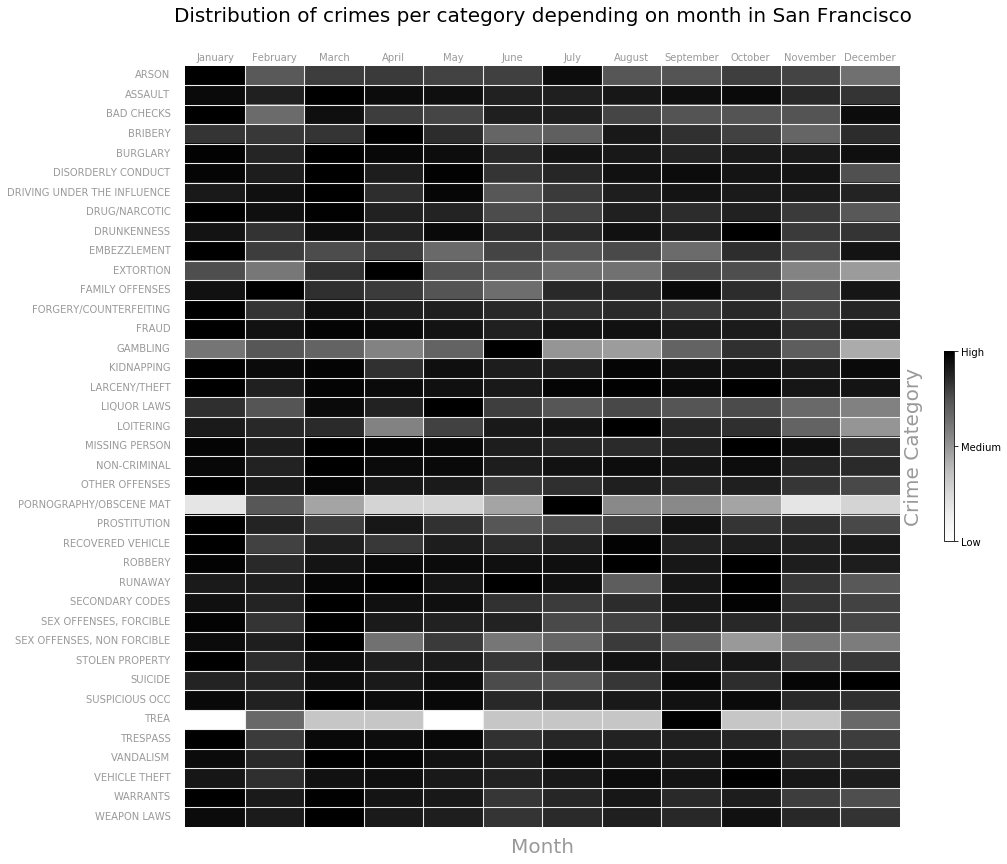

In [166]:
# draw grid on axes
fig, ax = preparePlot(np.arange(.5, 11, 1), np.arange(.5, n_categories-1, 1), figsize=(16,14), hideLabels=True,
                      gridColor='#eeeeee', gridWidth=1.1)

# interpolate crime intensity per hour on the grid
image = plt.imshow(img_month_cat, interpolation='nearest', aspect='auto', cmap=cm.Greys)

# x-axis labels
for x, y, s in zip(np.arange(0, 24, 1), np.repeat(-.75, 24), months):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="center")
# y-axis labels
for x, y, s in zip(np.repeat(-.75, n_categories), np.arange(.125, n_categories, 1), categories):
    plt.text(x, y, s, color='#999999', size='10', horizontalalignment="right")
# title, xlabel, ylabel
plt.title("Distribution of crimes per category depending on month in San Francisco", size=20, y=1.05)
plt.xlabel("Month", color='#999999', size="20")
plt.ylabel("Crime Category", color='#999999', size="20")

ax.yaxis.set_label_position("right")

# plot the colobar to show scale
cbar = fig.colorbar(image, ticks=[0, 0.5, 1], shrink=0.25, orientation='vertical')
cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

plt.show()